### Affinity Catalogs

An <i>affinity catalog</i> is created by running the design process multiple times with differing strengths of the design target. Even when one has a specific target value in mind, these catalogs are useful for several reasons. First, they provide context for each of the proposed edits at the target value by showing whether the edit is preserved across several runs of increasing strength, just noise, or just an artifact of the specific chosen value. Second, a single output loss can be difficult to interpret but comparing the entire curve of output losses from very easy to very difficult design tasks can be easier to interpret. Third, by considering the alternative usages of binding sites, one may realize that the specific value chosen may result in design oddities and choose a different target value that makes more sense.

Ledidi makes designing affinity catalogs easy because it is each design step is extremely fast. Sometimes, Ledidi can design an entire affinity catalog in the same amount of time that alternative methods can take to do a single design (though this is very model- and task-specific).

To design an affinity catalog, all one needs to do is use the same `ledidi` function as before but pass in a list of desired outputs instead of a single tensor. The design process is then repeated for each element in the list and the designs are stacked together, adding an additional dimension to the output.

#### Creating a GATA2 Affinity Catalog

As a conceptually simple example, let's begin by loading up the GATA2 BPNet model and designing an affinity catalog. We will load the model in the same way as before.

In [1]:
import torch

from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper

bpnet = torch.load("../../../../models/bpnet/GATA2.torch", weights_only=False)
bpnet = CountWrapper(ControlWrapper(bpnet))

As with out other examples we will generate a random sequence, but this is not because we need to use a random sequence to design an affinity catalog (or even recommend it in practice). Rather, it is just because our goal is to demonstrate how to make an affinity catalog.

In [2]:
from tangermeme.utils import random_one_hot
from tangermeme.predict import predict

X = random_one_hot((1, 4, 2114), random_state=0).float()

predict(bpnet, X)

tensor([[0.7167]])

Looks like the initial predicted value is quite low.

Now, we can generate our affinity catalog. All we need to do this is pass in a list for `y_bar` instead of a single tensor. At each step the same initial sequence is used but a different desired target is specified.

In [3]:
from ledidi import ledidi

y_bar = [torch.tensor([[0.0]]), torch.tensor([[1.0]]), torch.tensor([[2.0]]), torch.tensor([[3.0]])]
X_bars = ledidi(bpnet, X, y_bar, l=0.001, verbose=False)
X_bars.shape

torch.Size([4, 16, 4, 2114])

You will notice that there is an additional dimension at the front of the designed sequences corresponding to the length of the affinity catalog. Since we have set there to be four steps in the catalog, there are four sets of designed sequences. We can still generate any number of edited sequences at each step.

We can validate that the design worked by checking the predicted values for one of the designs at each of the steps.

In [4]:
predict(bpnet, X_bars[:, 0])

tensor([[0.0079],
        [1.0228],
        [1.9961],
        [2.9589]])

Great, looks like the designed edits are inducing the range of values expected by the catalog!

In practice, we expect one to want to look at a more fine-grained catalog that goes further out. So, let's take a look at one. Remember that we still need to pass in a list object even when the desired outputs could be easily expressed as a range. This is because passing in a single tensor -- even one with an additional dimension compared to what one might normally expect -- can become ambiguous and a source of unintentional bugs. I have found that it is better to be explicit about these sorts of things even if it requires a little bit more work.

In [5]:
y_ = torch.arange(0, 6.1, 0.25)
y_bar = [torch.tensor([[y]]) for y in y_]

X_bars = ledidi(bpnet, X, y_bar, n_samples=1, l=0.001, verbose=False)
y_hat = predict(bpnet, X_bars[:, 0])

print(X_bars.shape, y_hat.shape)

torch.Size([25, 1, 4, 2114]) torch.Size([25, 1])


Great, looks like we have gotten a catalog of designs with the expected shape. Now we can check to see whether the predicted activities for these edited sequences match what we wanted the catalog to cover.

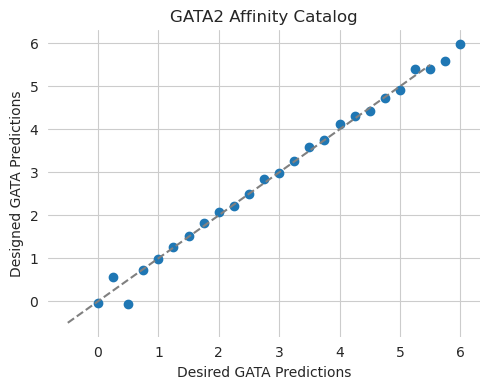

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(5, 4))
plt.title("GATA2 Affinity Catalog")
plt.xlabel("Desired GATA Predictions")
plt.ylabel("Designed GATA Predictions")

plt.scatter(y_, y_hat)
plt.plot([-0.5, 5.5], [-0.5, 5.5], c='0.5', linestyle='--')

plt.tight_layout()
seaborn.despine(bottom=True, left=True)
plt.show()

Looks like we are pretty much on the curve! This is not super surprising, in retrospect, because we are evaluating the predictions using the same model that we used for design and we are only considering a somewhat compact range.

#### Inspecting an Affinity Catalog

Now that we have an affinity catalog, we can inspect it to see what was learned at each step in the process. We can do this by running DeepLIFT/SHAP on a design from each step in the process and plotting the attributions. As an initial high-level overview we can use a series of scatterplots to visualize the attributions at each of the steps in the catalog.

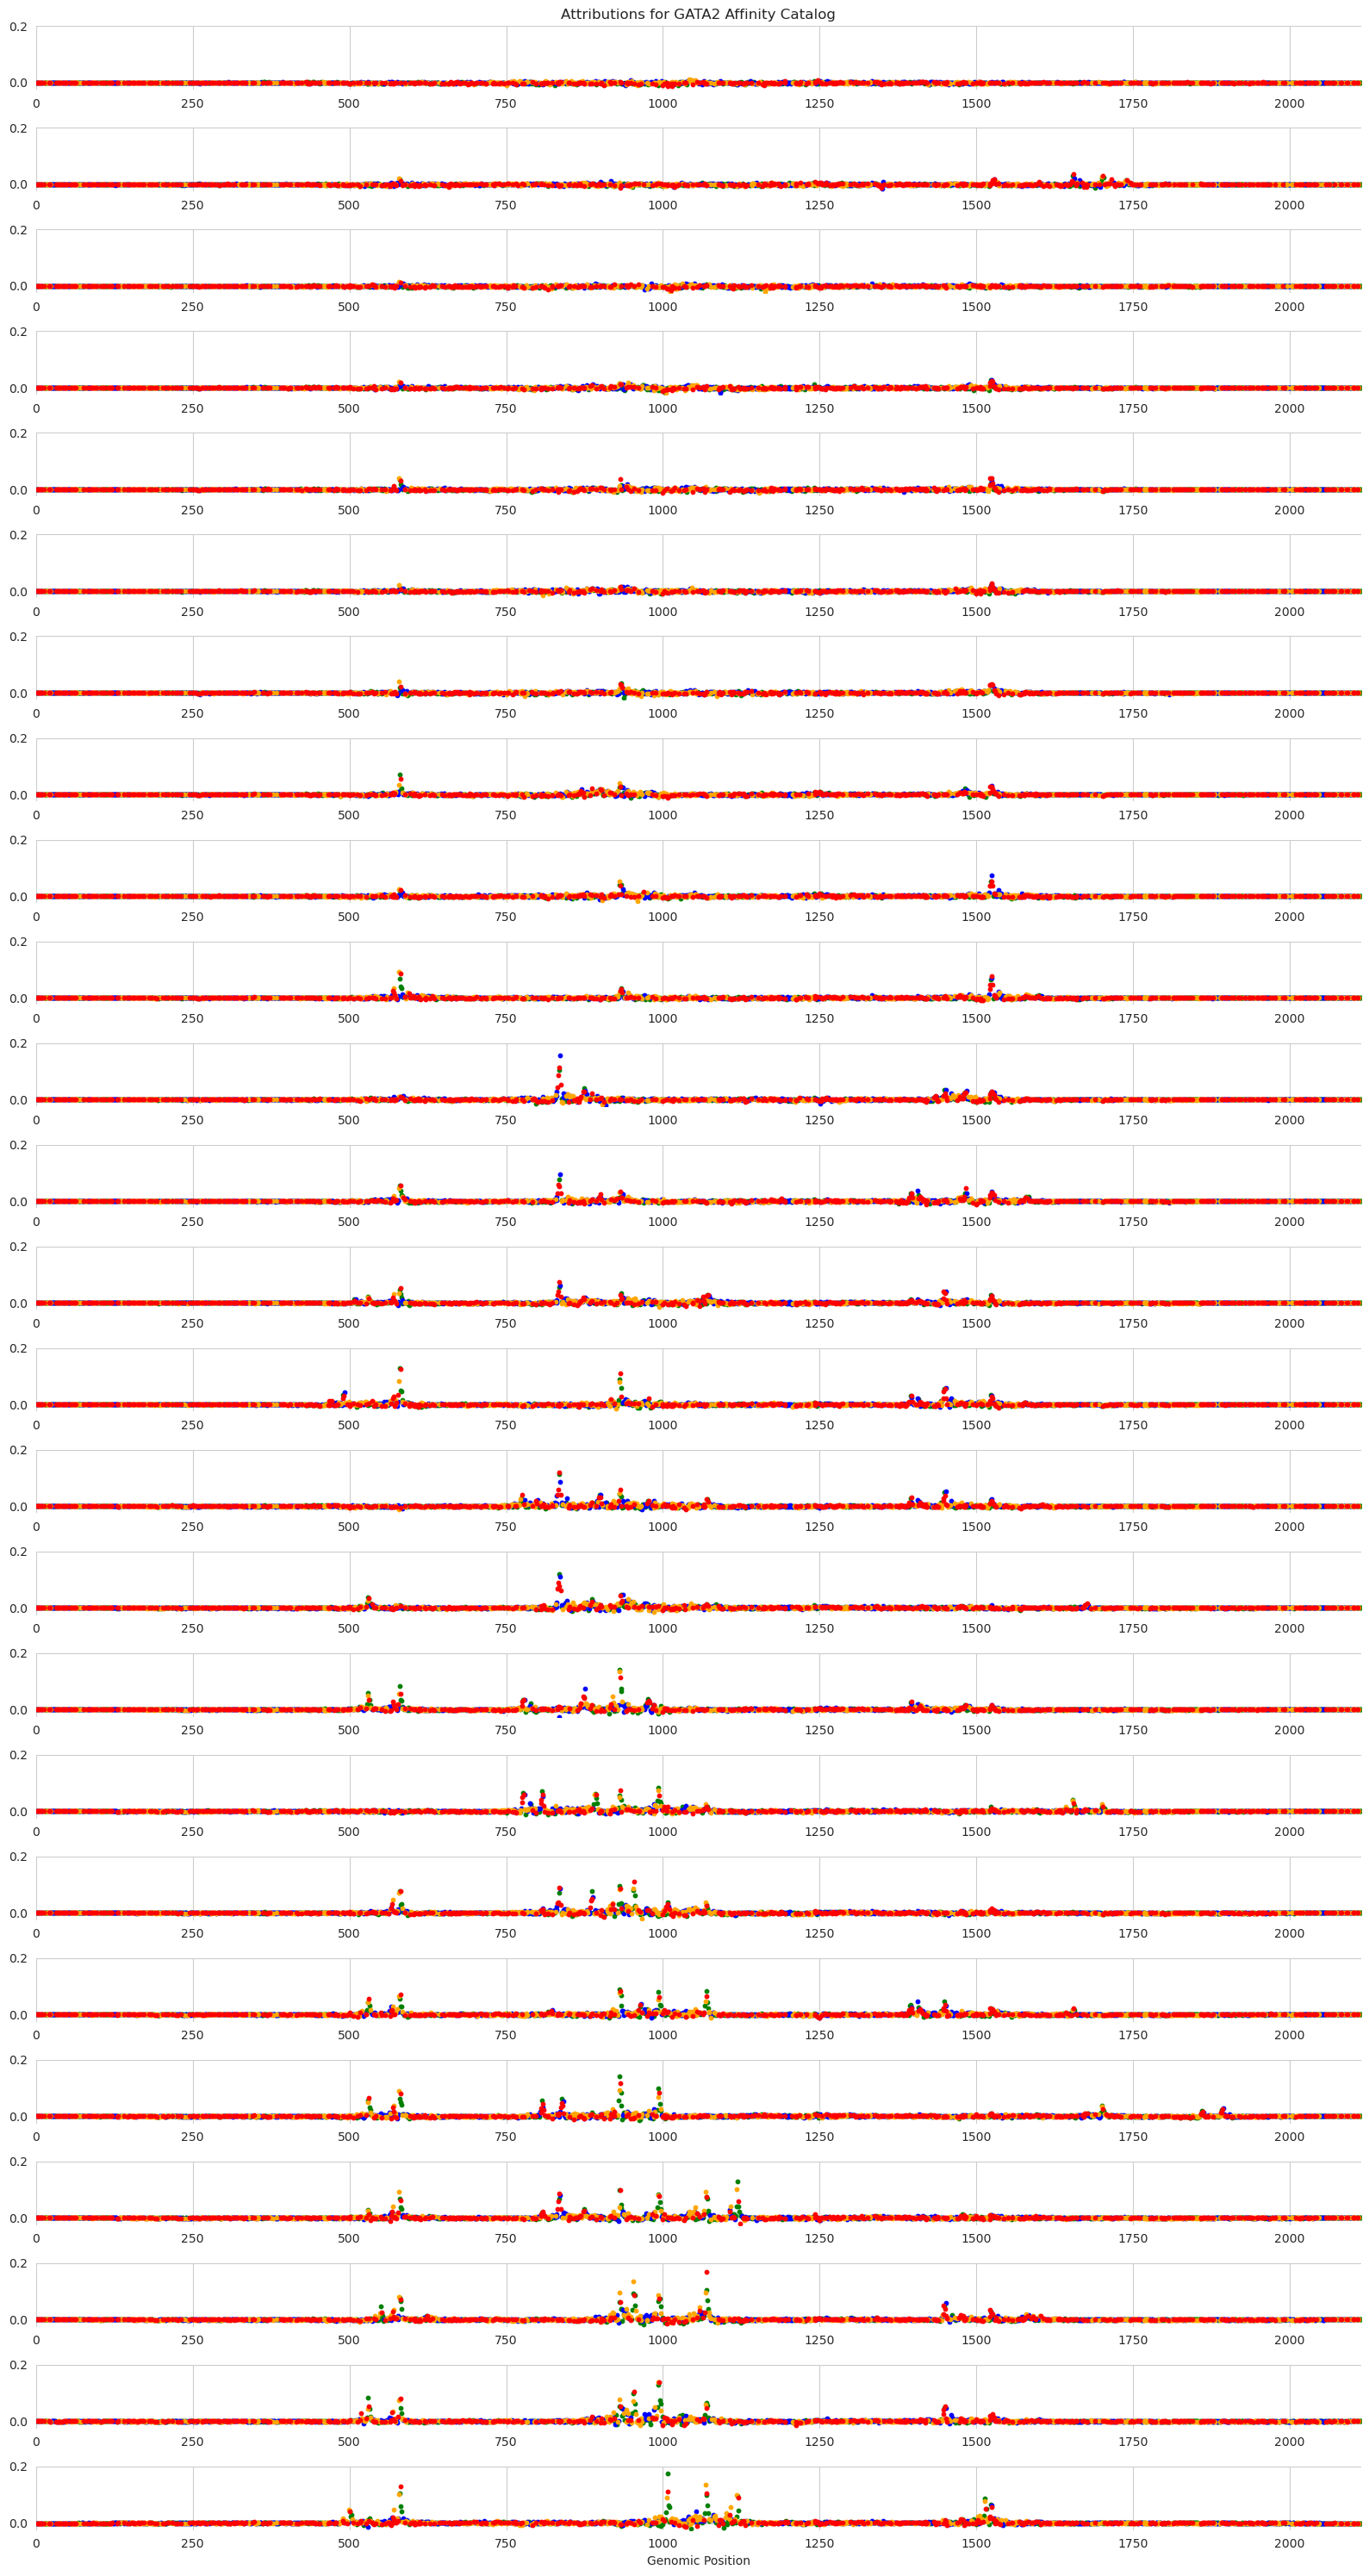

In [7]:
from tangermeme.deep_lift_shap import deep_lift_shap
from tangermeme.plot import plot_categorical_scatter

X_attr = deep_lift_shap(bpnet, X_bars[:, 0]).detach()
n = len(X_attr)

plt.figure(figsize=(16, 30))

for i in range(n):
    plt.subplot(n, 1, i+1)
    plot_categorical_scatter(X_attr[i], s=10)
    
    if i == 0:
        plt.title("Attributions for GATA2 Affinity Catalog")
    if i == n-1:
        plt.xlabel("Genomic Position")
    
    plt.ylim(-0.025, .2)
    plt.xlim(0, 2114)
    seaborn.despine(bottom=True, left=True)

plt.tight_layout()
plt.show()

Each panel in this figure shows the attributions at a different step in the catalog, with the top of the figure showing very low desired output from the GATA2 model and the bottom showing very high desired output. The y-axis shows the strength of the attributions, with higher values meaning that that nucleotide is more important for model predictions and sets of adjacent high-attribution characters likely forming motifs.

Looking across the panels, we can see interesting alternating patterns of usage. These patterns arise due to two reasons. The first is that Ledidi is trying to minimize the number of edits made and so will preferentially target regions that are almost-GATA. The set of regions that are targeted across the entire catalog are likely all almost-GATA. The second reason is that <i>Ledidi is trying to match a precise desired output</i>. In order to <i>precisely</i> match a value of 4, Ledidi may need to rely on suboptimal spacing or affinity at some of the sites. Ledidi may even need to swap out a high affinity site for two low affinity sites to get to the next level of prediction strength.

Unfortunately, most people do not have screens that are wide enough to visualize all 2,114bp characters as one sees in the normal attribution plots. But, from the scatterplots, it looks like an interesting region to visualize is the 750-1050bp span. Let's zoom in on that.

As a side note, the `plot_attributions` function here may be particularly useful for people looking to visualize these catalogs. It takes in a set of sequences and a model and will handle both the running of the attribution algorithm (which can be passed in but defaults to DeepLIFT/SHAP) and the plotting of the results.

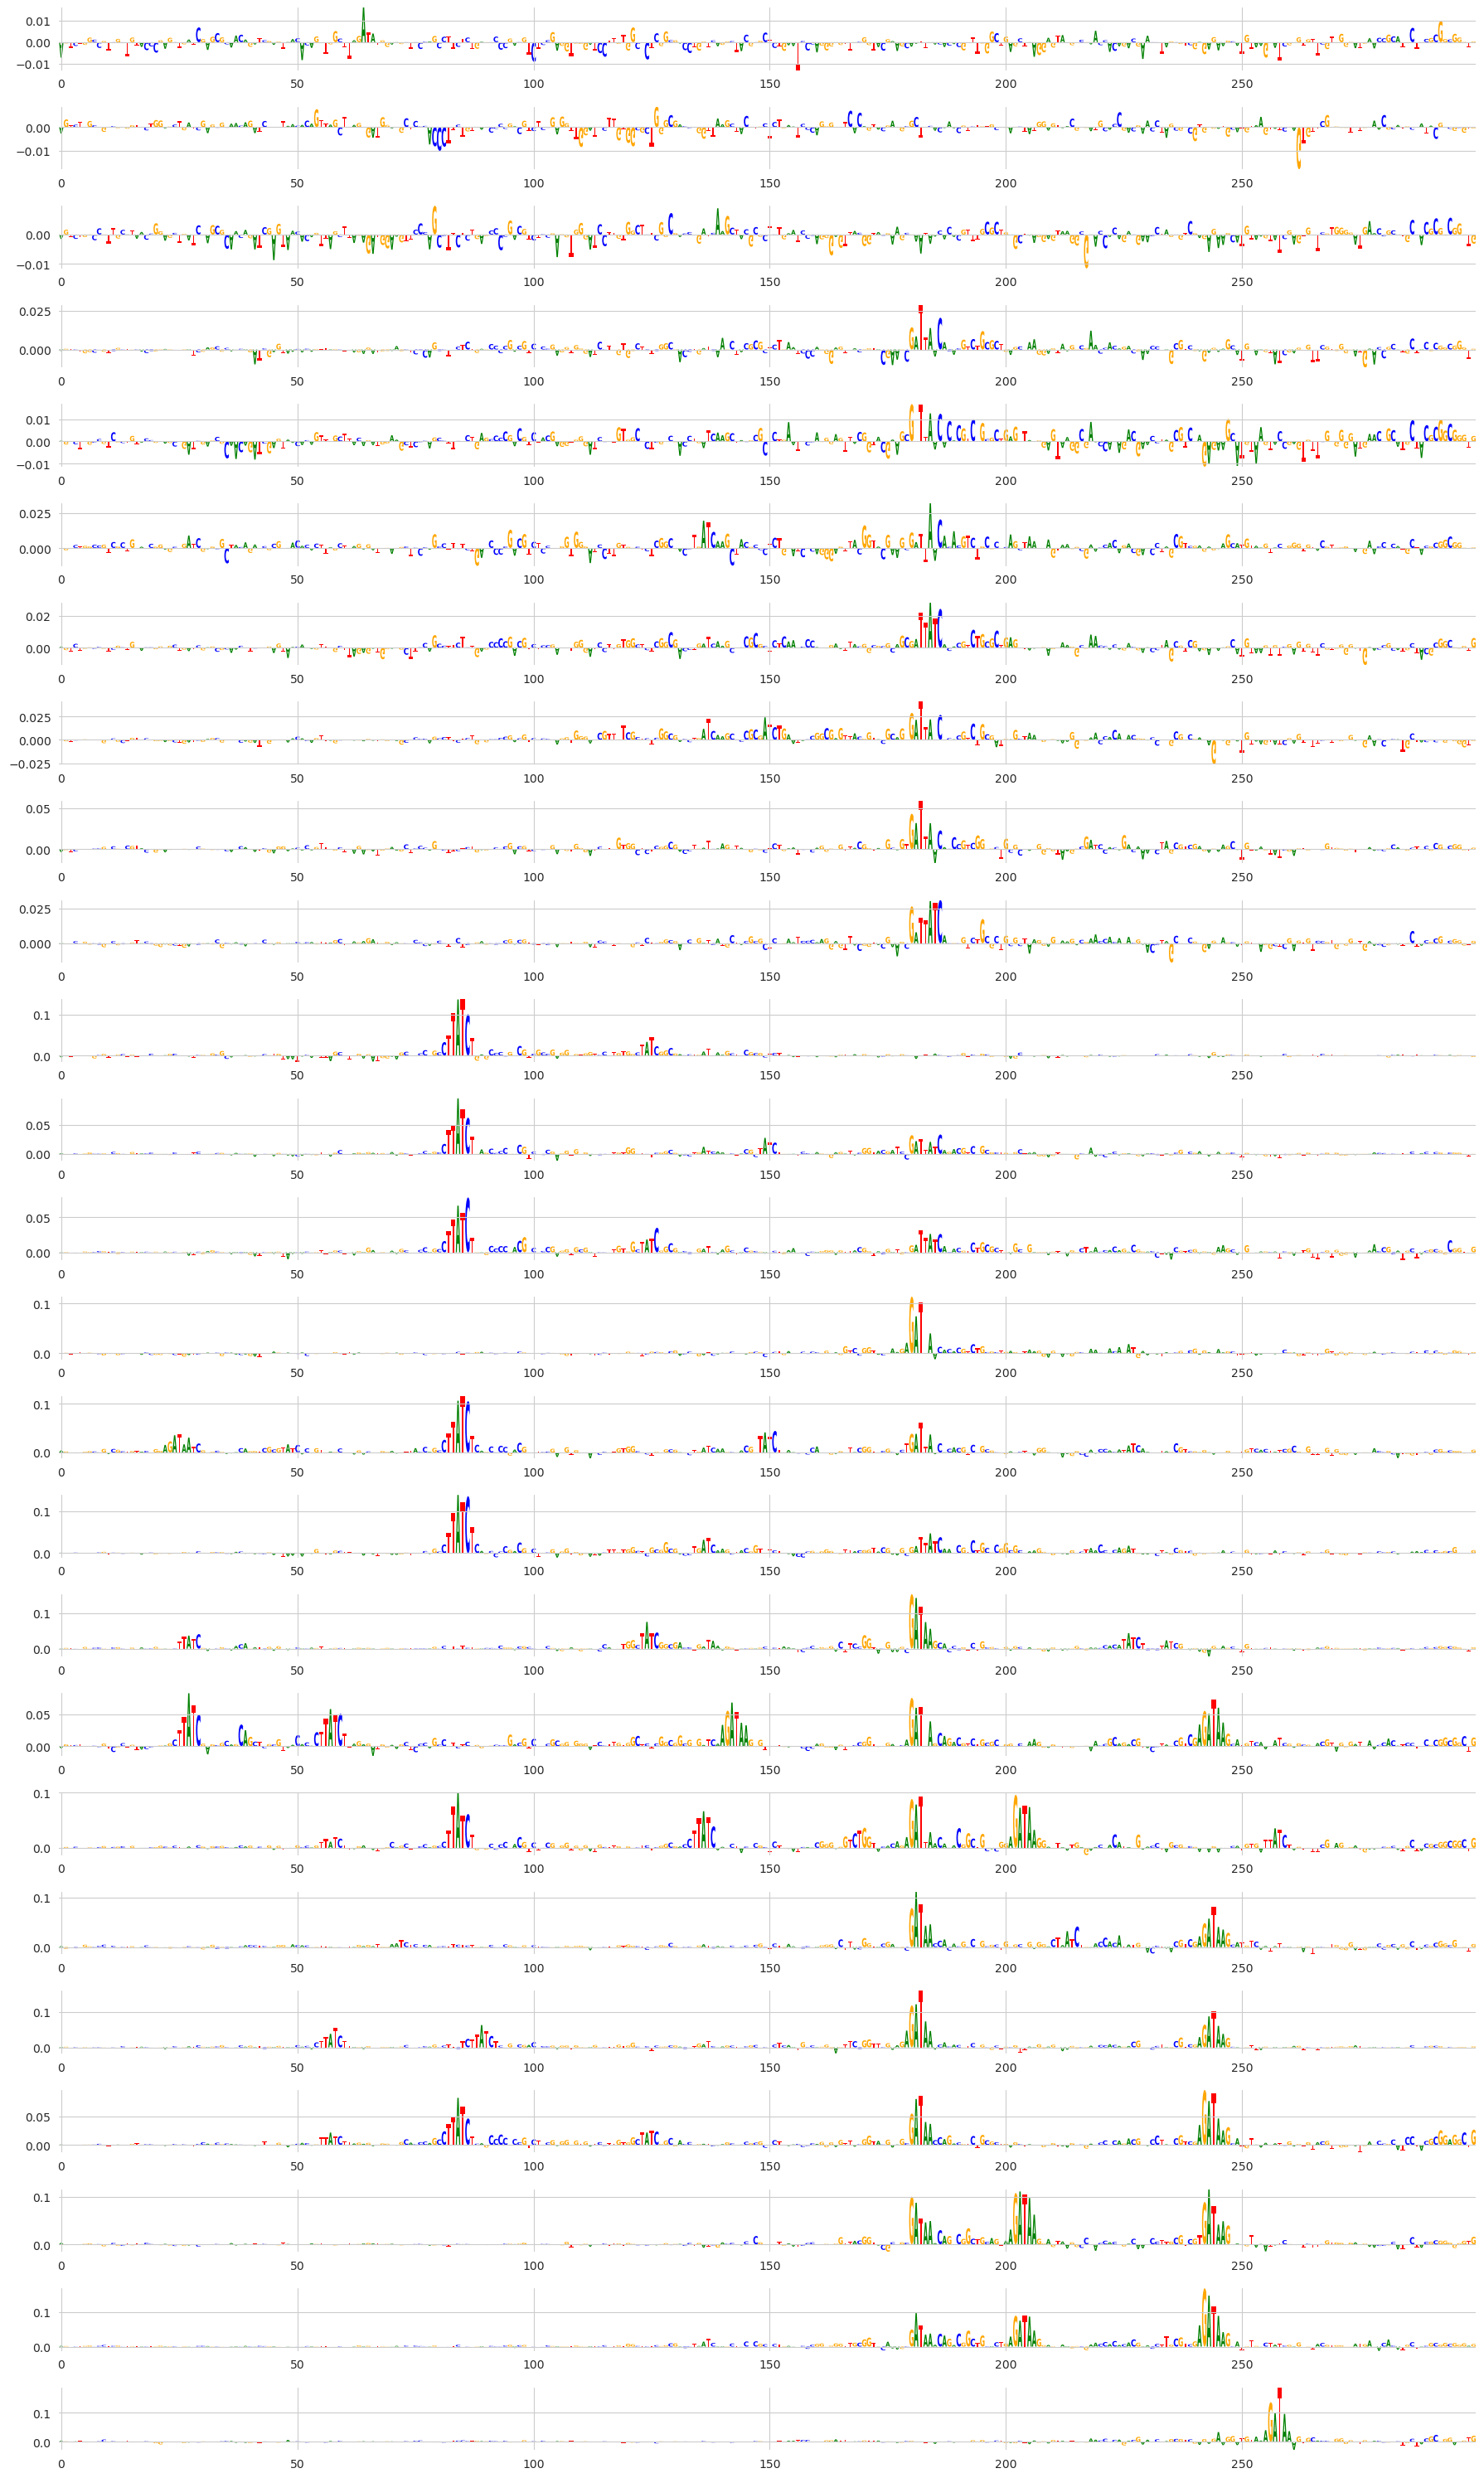

In [8]:
from tangermeme.plot import plot_attributions

plt.figure(figsize=(18, 30))
plot_attributions(bpnet, X_bars[:, 0], plot_kwargs={'start': 750, 'end': 1050})

plt.tight_layout()
plt.show()

By zooming into this region we can see that, indeed, the same motifs are being re-used across steps in the affinity catalog. I personally find it very fascinating to see motifs popping in and out across the steps in the catalog, especially combined with our initial result showing that the actual predictions from the model are very closely matching the desired output. 

#### Affinity Catalogs with Multiple Outputs

So far, we have shown an affinity catalog being designed using just one output. However, affinity catalogs can be designed in any scenario that normal design can be done, including with in-painting and masking constraints.

As a demonstration, we will design affinity catalogs using the Malinois model where we want to increase predicted MPRA activity using the K562 head but keep predictions using the other two heads low. Basically, we are not designing a single cell type-specific element, but rather creating a catalog of cell type-specificity.

First, we need to load the Malinois model.

In [9]:
from boda.model import BassetBranched

checkpoint = torch.load("../../../../models/malinois/torch_checkpoint.pt", weights_only=False)
malinois = BassetBranched(**vars(checkpoint['model_hparams']))
malinois.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Then, we create a new randomly generated sequence of the correct length and show that predictions are low on it.

In [10]:
X = random_one_hot((1, 4, 600), random_state=0).float()
predict(malinois, X)

tensor([[ 0.0266,  0.1797, -0.1829]])

Now, we can create an affinity catalog. Just as before, we need our `y_bars` to be a list of tensors. Because we want to do multi-output design, each one of these tensors needs to have a value for each of the three outputs in the Malinois model. These values can be anything but we will set them such that the K562 predictions are increasing in each step and the other two are set to 0 at each step.

In [11]:
y_ = torch.arange(1, 6.1, 0.5)
y_bars = [torch.tensor([[y_, 0, 0]]) for y_ in y_]

X_bars = ledidi(malinois, X, y_bars, l=0.001, n_samples=1, verbose=False)[:, 0]
y_hats = predict(malinois, X_bars)

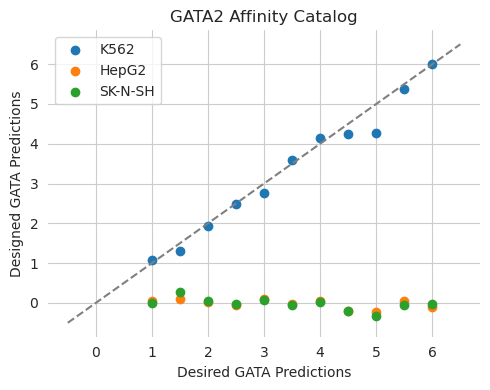

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

plt.figure(figsize=(5, 4))
plt.title("GATA2 Affinity Catalog")
plt.xlabel("Desired GATA Predictions")
plt.ylabel("Designed GATA Predictions")

plt.scatter(y_, y_hats[:, 0], label="K562")
plt.scatter(y_, y_hats[:, 1], label="HepG2")
plt.scatter(y_, y_hats[:, 2], label="SK-N-SH")
plt.plot([-0.5, 6.5], [-0.5, 6.5], c='0.5', linestyle='--')
plt.legend()

plt.tight_layout()
seaborn.despine(bottom=True, left=True)
plt.show()

Looks the way we would expect it to! The predictions from the edited sequences show that the K562 predictions increase at each step but the HepG2 and SK-N-SH predictions remain the same.